# Train on Photo, and Test on Art_painting without adaptation


**Install requirements**

In [0]:
# !pip3 install 'torch==1.3.1'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                    #   transforms.RandomCrop( 64 , padding =2) ,
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizes with mean and standard deviation of ImageNet
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                    
])

**Prepare Dataset**

In [0]:
# Clone github repository with data
if not os.path.isdir('./PACS'):
#   !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
    !git clone https://github.com/MachineLearning2020/Homework3-PACS.git
    !mv 'Homework3-PACS' 'PACS'

DATA_DIR = 'PACS/PACS'
P_DIR = os.path.join(DATA_DIR, 'photo')
A_DIR = os.path.join(DATA_DIR, 'art_painting')

In [49]:
# Prepare Pytorch train/test Datasets
train_dataset = torchvision.datasets.ImageFolder(P_DIR, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(A_DIR, transform=eval_transform)

# train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
# test_indexes = [idx for idx in range(len(test_dataset)) if not idx % 5]

# train_dataset = Subset(train_dataset, train_indexes)
# test_dataset = Subset(test_dataset, test_indexes)

# Check dataset sizes
print('Photo Dataset: {}'.format(len(train_dataset)))
print('Art painting Dataset: {}'.format(len(test_dataset)))

Photo Dataset: 1670
Art painting Dataset: 2048


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
net = alexnet(pretrained=True)     # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [53]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

loss_hist = []
acc_hist = []

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  running_corrects = 0
  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)
    running_corrects += torch.sum(preds == labels.data).data.item()

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Step the scheduler
  scheduler.step() 

  # Calculate Accuracy for each epoch
  accuracy = running_corrects / float(len(train_dataset))
  print('Accuracy {}\n'.format(accuracy))

  # Record loss and accuracy after each epoch
  loss_hist.append(loss.item())
  acc_hist.append(accuracy)

Starting epoch 1/30, LR = [0.001]
Step 0, Loss 2.16227650642395
Accuracy 0.4341317365269461

Starting epoch 2/30, LR = [0.001]
Step 10, Loss 0.4003186821937561
Accuracy 0.7922155688622754

Starting epoch 3/30, LR = [0.001]
Accuracy 0.8622754491017964

Starting epoch 4/30, LR = [0.001]
Step 20, Loss 0.16134735941886902
Accuracy 0.8760479041916168

Starting epoch 5/30, LR = [0.001]
Accuracy 0.8898203592814371

Starting epoch 6/30, LR = [0.001]
Step 30, Loss 0.10443335771560669
Accuracy 0.8934131736526946

Starting epoch 7/30, LR = [0.001]
Step 40, Loss 0.05575740337371826
Accuracy 0.8934131736526946

Starting epoch 8/30, LR = [0.001]
Accuracy 0.8988023952095808

Starting epoch 9/30, LR = [0.001]
Step 50, Loss 0.04999367147684097
Accuracy 0.9005988023952096

Starting epoch 10/30, LR = [0.001]
Accuracy 0.9065868263473054

Starting epoch 11/30, LR = [0.0001]
Step 60, Loss 0.03336291015148163
Accuracy 0.907185628742515

Starting epoch 12/30, LR = [0.0001]
Step 70, Loss 0.04480801895260811
Ac

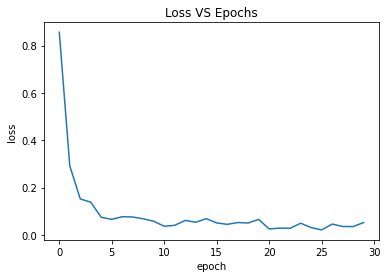

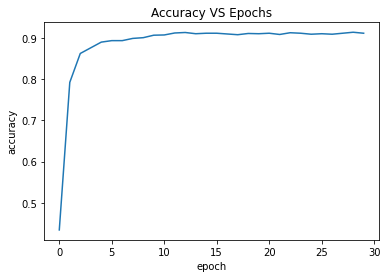

In [54]:
plt.plot(loss_hist)
plt.title('Loss VS Epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

plt.plot(acc_hist)
plt.title('Accuracy VS Epochs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**Test**

In [55]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Test Accuracy: 0.46484375


# Implementation of DANN

In [0]:
from PACS.gradient_reversal_example import ReverseLayerF
from torchvision.models import AlexNet
from torchvision.models.utils import load_state_dict_from_url
from copy import deepcopy

In [0]:
class DANN(AlexNet):
    def __init__(self):
        super(DANN, self).__init__()
        self.domain_clf = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
        )
    
    def forward(self, x, alpha=None):
        x = self.features(x)
        x = self.avgpool(x)
        # Flatten the features:
        x = x.view(x.size(0), -1)
        # If we pass alpha, we can assume we are training the discriminator
        if alpha is not None:
            # gradient reversal layer (backward gradients will be reversed)
            reverse_feature = ReverseLayerF.apply(x, alpha)
            discriminator_output = self.domain_clf(x)
            return discriminator_output
        # If we don't pass alpha, we assume we are training with supervision
        else:
            # do something else
            class_outputs = self.classifier(x)
            return class_outputs

In [0]:
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

In [0]:
def dann(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = DANN(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict, strict=False)
    return model

# Train DANN on Photo and test on Art_painting with DANN adaptation

**Prepare Network**

In [0]:
net = dann(pretrained=True)     # Loading DANN model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 7 outputs for PACS
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

In [36]:
net

DANN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    

In [0]:
# copy weights of label classiﬁer into domain classiﬁer
net.domain_clf[1].weight.data = net.classifier[1].weight.data
net.domain_clf[1].bias.data = net.classifier[1].bias.data

net.domain_clf[4].weight.data = net.classifier[4].weight.data
net.domain_clf[4].bias.data = net.classifier[4].bias.data

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [0]:
ALPHA = 0.3

In [40]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

loss_Gy_hist = []
loss_Gd_0_hist = []
loss_Gd_1_hist = []
# acc_Gy_hist = []
# acc_Gd_0_hist = []
# acc_Gd_1_hist = []

# current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

#   running_corrects = 0
  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # 3B.1 Train Gy
    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    loss.backward()  # backward pass: computes gradients

    # 3B.2 Train Gd by forwarding source data
    label_outputs = net.forward(images, ALPHA)
    targets = torch.zeros(labels.shape, dtype=int).to(DEVICE)

    loss_Gd_0 = criterion(label_outputs, targets)
    loss_Gd_0.backward()

    # 3B.3 Train Gd by forwarding target data
    test_images, test_labels = next(iter(test_dataloader))
    test_images = test_images.to(DEVICE)
    test_labels = test_labels.to(DEVICE)

    test_label_outputs = net.forward(test_images, ALPHA)
    targets = torch.ones(test_labels.shape, dtype=int).to(DEVICE)

    loss_Gd_1 = criterion(test_label_outputs, targets)
    loss_Gd_1.backward()

    # update weights based on accumulated gradients
    optimizer.step() 

    # current_step += 1

  # Step the scheduler
  scheduler.step() 

  # Calculate Accuracy for each epoch
#   accuracy = running_corrects / float(len(train_dataset))
#   print('Accuracy {}\n'.format(accuracy))


  # Log loss
  print('Gy  Loss {}'.format(loss.item()))
  print('Gd0 Loss {}'.format(loss_Gd_0.item()))
  print('Gd1 Loss {}'.format(loss_Gd_1.item()))

  # Record loss and accuracy after each epoch
  loss_Gy_hist.append(loss.item())
  loss_Gd_0_hist.append(loss_Gd_0)
  loss_Gd_1_hist.append(loss_Gd_1)
#   acc_hist.append(accuracy)

Starting epoch 1/30, LR = [0.001]
Gy  Loss 0.901157796382904
Gd0 Loss 0.20195943117141724
Gd1 Loss 0.10127934068441391
Starting epoch 2/30, LR = [0.001]
Gy  Loss 0.35205432772636414
Gd0 Loss 0.06680424511432648
Gd1 Loss 0.15828478336334229
Starting epoch 3/30, LR = [0.001]
Gy  Loss 0.20151999592781067
Gd0 Loss 0.08177643269300461
Gd1 Loss 0.053006380796432495
Starting epoch 4/30, LR = [0.001]
Gy  Loss 0.13330674171447754
Gd0 Loss 0.08776810765266418
Gd1 Loss 0.05539451539516449
Starting epoch 5/30, LR = [0.001]
Gy  Loss 0.08622752875089645
Gd0 Loss 0.030922625213861465
Gd1 Loss 0.012315072119235992
Starting epoch 6/30, LR = [0.001]
Gy  Loss 0.09335143119096756
Gd0 Loss 0.026305973529815674
Gd1 Loss 0.02738126367330551
Starting epoch 7/30, LR = [0.001]
Gy  Loss 0.06361090391874313
Gd0 Loss 0.03105231560766697
Gd1 Loss 0.005412285216152668
Starting epoch 8/30, LR = [0.001]
Gy  Loss 0.05566440522670746
Gd0 Loss 0.01883179321885109
Gd1 Loss 0.016275864094495773
Starting epoch 9/30, LR = [0

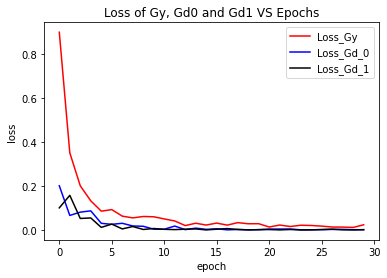

In [43]:
import matplotlib.pyplot as plt

plt.plot(loss_Gy_hist, color='red')
plt.plot(loss_Gd_0_hist, color='blue')
plt.plot(loss_Gd_1_hist, color='black')
plt.title('Loss of Gy, Gd0 and Gd1 VS Epochs')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Loss_Gy', 'Loss_Gd_0', 'Loss_Gd_1'])
plt.show()

**Test**

In [44]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in test_dataloader:
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

Test Accuracy: 0.49169921875


# Hyperparameter optimization for both 3A and 3B 

In [0]:
STEP_SIZE = 10
lr_choices = [1e-3, 1e-4, 1e-5]
alpha_choices = [0.1, 0.3, 1, 3, 10]

In [0]:
def plot_loss(lr, alpha, loss_Gy_hist, loss_Gd_0_hist, loss_Gd_1_hist):
    plt.plot(loss_Gy_hist, color='red')
    plt.plot(loss_Gd_0_hist, color='blue')
    plt.plot(loss_Gd_1_hist, color='black')
    plt.title('Losses where lr = {} and alpha = {}'.format(lr, alpha))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Loss_Gy', 'Loss_Gd_0', 'Loss_Gd_1'])
    plt.show()

In [0]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

logname = 'DANN.log'
handler = logging.FileHandler(logname)
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(lineno)d - %(message)s'
)
handler.setFormatter(formatter)
logger.addHandler(handler)

In [0]:
best_accuracy = 0

In [41]:
from google.colab import drive
if os.path.exists('/gdrive'):
    !ls '/gdrive/My Drive'
else:
    drive.mount('/gdrive')

'Colab Notebooks'    'Ingegneria informatica (Computer Engineering)'
'CSSA POLITO'	      Screenshot_2018-10-12-11-05-31-351_com.android.mms.png
 DANN0.log	      Upload
 Data		      人事部2019
 Graduation_Project   都灵理工大学新生指南2015.doc.gdoc


Starting epoch 1/30, LR = [0.001], alpha = 0.1
Gy  Loss 0.8458294868469238
Gd0 Loss 0.14487795531749725
Gd1 Loss 0.13148394227027893
Starting epoch 2/30, LR = [0.001], alpha = 0.1
Gy  Loss 0.3186875283718109
Gd0 Loss 0.07707293331623077
Gd1 Loss 0.07507862150669098
Starting epoch 3/30, LR = [0.001], alpha = 0.1
Gy  Loss 0.157643124461174
Gd0 Loss 0.03681812062859535
Gd1 Loss 0.057085245847702026
Starting epoch 4/30, LR = [0.001], alpha = 0.1
Gy  Loss 0.17169830203056335
Gd0 Loss 0.0243376474827528
Gd1 Loss 0.02207452990114689
Starting epoch 5/30, LR = [0.001], alpha = 0.1
Gy  Loss 0.1259925663471222
Gd0 Loss 0.049703583121299744
Gd1 Loss 0.016473310068249702
Starting epoch 6/30, LR = [0.001], alpha = 0.1
Gy  Loss 0.11216568201780319
Gd0 Loss 0.01316672284156084
Gd1 Loss 0.01299937255680561
Starting epoch 7/30, LR = [0.001], alpha = 0.1
Gy  Loss 0.08345203101634979
Gd0 Loss 0.005899121984839439
Gd1 Loss 0.016259536147117615
Starting epoch 8/30, LR = [0.001], alpha = 0.1
Gy  Loss 0.03386

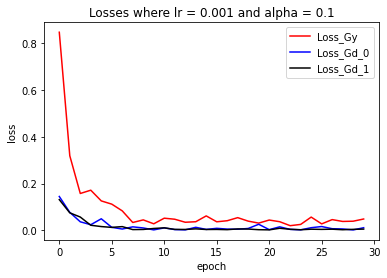

Test Accuracy: 0.482421875
Starting epoch 1/30, LR = [0.001], alpha = 0.3
Gy  Loss 0.8294925093650818
Gd0 Loss 0.17367364466190338
Gd1 Loss 0.12926620244979858
Starting epoch 2/30, LR = [0.001], alpha = 0.3
Gy  Loss 0.2848312258720398
Gd0 Loss 0.09970337897539139
Gd1 Loss 0.0871179923415184
Starting epoch 3/30, LR = [0.001], alpha = 0.3
Gy  Loss 0.13806983828544617
Gd0 Loss 0.02695884183049202
Gd1 Loss 0.06073402613401413
Starting epoch 4/30, LR = [0.001], alpha = 0.3
Gy  Loss 0.1563684642314911
Gd0 Loss 0.034002553671598434
Gd1 Loss 0.029231512919068336
Starting epoch 5/30, LR = [0.001], alpha = 0.3
Gy  Loss 0.11808736622333527
Gd0 Loss 0.030443843454122543
Gd1 Loss 0.010492502711713314
Starting epoch 6/30, LR = [0.001], alpha = 0.3
Gy  Loss 0.14312554895877838
Gd0 Loss 0.02021610550582409
Gd1 Loss 0.01725803129374981
Starting epoch 7/30, LR = [0.001], alpha = 0.3
Gy  Loss 0.09879326820373535
Gd0 Loss 0.02435161918401718
Gd1 Loss 0.011096412315964699
Starting epoch 8/30, LR = [0.001],

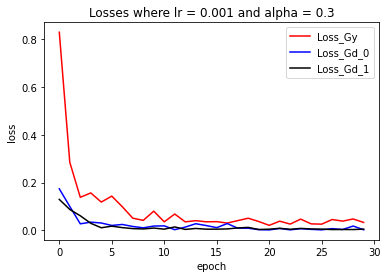

Test Accuracy: 0.48291015625
Starting epoch 1/30, LR = [0.001], alpha = 1
Gy  Loss 0.8005067706108093
Gd0 Loss 0.1861039102077484
Gd1 Loss 0.12968893349170685
Starting epoch 2/30, LR = [0.001], alpha = 1
Gy  Loss 0.3131597936153412
Gd0 Loss 0.15308329463005066
Gd1 Loss 0.11783330887556076
Starting epoch 3/30, LR = [0.001], alpha = 1
Gy  Loss 0.16650809347629547
Gd0 Loss 0.06752319633960724
Gd1 Loss 0.049495160579681396
Starting epoch 4/30, LR = [0.001], alpha = 1
Gy  Loss 0.14422012865543365
Gd0 Loss 0.08927655220031738
Gd1 Loss 0.02947540581226349
Starting epoch 5/30, LR = [0.001], alpha = 1
Gy  Loss 0.09842917323112488
Gd0 Loss 0.013318536803126335
Gd1 Loss 0.01828218251466751
Starting epoch 6/30, LR = [0.001], alpha = 1
Gy  Loss 0.11281953752040863
Gd0 Loss 0.0159386545419693
Gd1 Loss 0.013465002179145813
Starting epoch 7/30, LR = [0.001], alpha = 1
Gy  Loss 0.09490786492824554
Gd0 Loss 0.015246530994772911
Gd1 Loss 0.009684390388429165
Starting epoch 8/30, LR = [0.001], alpha = 1
G

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-9seu3srx'


Gy  Loss 0.048451561480760574
Gd0 Loss 0.005870755296200514
Gd1 Loss 0.005457231309264898
Starting epoch 11/30, LR = [0.0001], alpha = 1
Gy  Loss 0.04814039170742035
Gd0 Loss 0.003443205263465643
Gd1 Loss 0.004940766841173172
Starting epoch 12/30, LR = [0.0001], alpha = 1
Gy  Loss 0.056232765316963196
Gd0 Loss 0.008393418043851852
Gd1 Loss 0.00835635419934988
Starting epoch 13/30, LR = [0.0001], alpha = 1
Gy  Loss 0.08413417637348175
Gd0 Loss 0.007085243705660105
Gd1 Loss 0.004162034019827843
Starting epoch 14/30, LR = [0.0001], alpha = 1
Gy  Loss 0.01999727450311184
Gd0 Loss 0.005175393540412188
Gd1 Loss 0.004854840692132711
Starting epoch 15/30, LR = [0.0001], alpha = 1
Gy  Loss 0.0267416350543499
Gd0 Loss 0.00811726413667202
Gd1 Loss 0.010474408976733685
Starting epoch 16/30, LR = [0.0001], alpha = 1
Gy  Loss 0.04475904628634453
Gd0 Loss 0.004307802300900221
Gd1 Loss 0.0031514004804193974
Starting epoch 17/30, LR = [0.0001], alpha = 1
Gy  Loss 0.043514471501111984
Gd0 Loss 0.0067165

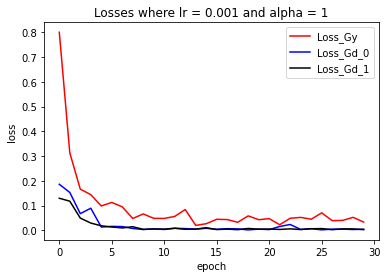

Test Accuracy: 0.45263671875
Starting epoch 1/30, LR = [0.001], alpha = 3
Gy  Loss 0.7859246730804443
Gd0 Loss 0.22765383124351501
Gd1 Loss 0.08932558447122574
Starting epoch 2/30, LR = [0.001], alpha = 3
Gy  Loss 0.25672388076782227
Gd0 Loss 0.055169712752103806
Gd1 Loss 0.1122557744383812
Starting epoch 3/30, LR = [0.001], alpha = 3
Gy  Loss 0.19880381226539612
Gd0 Loss 0.0785222128033638
Gd1 Loss 0.03360486403107643
Starting epoch 4/30, LR = [0.001], alpha = 3
Gy  Loss 0.12510502338409424
Gd0 Loss 0.02155403047800064
Gd1 Loss 0.05531122162938118
Starting epoch 5/30, LR = [0.001], alpha = 3
Gy  Loss 0.13009099662303925
Gd0 Loss 0.0343947559595108
Gd1 Loss 0.01861465536057949
Starting epoch 6/30, LR = [0.001], alpha = 3
Gy  Loss 0.08681166917085648
Gd0 Loss 0.045844875276088715
Gd1 Loss 0.011992081068456173
Starting epoch 7/30, LR = [0.001], alpha = 3
Gy  Loss 0.07303276658058167
Gd0 Loss 0.008751798421144485
Gd1 Loss 0.012385742738842964
Starting epoch 8/30, LR = [0.001], alpha = 3
G

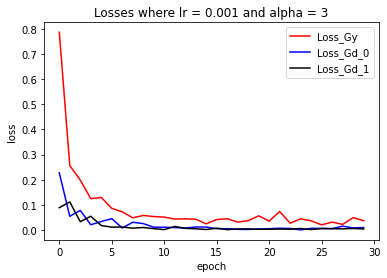

Test Accuracy: 0.48388671875
Starting epoch 1/30, LR = [0.001], alpha = 10
Gy  Loss 0.8624485731124878
Gd0 Loss 0.2811397314071655
Gd1 Loss 0.08063822239637375
Starting epoch 2/30, LR = [0.001], alpha = 10
Gy  Loss 0.3529903292655945
Gd0 Loss 0.05584424361586571
Gd1 Loss 0.13335061073303223
Starting epoch 3/30, LR = [0.001], alpha = 10
Gy  Loss 0.12747839093208313
Gd0 Loss 0.05563034117221832
Gd1 Loss 0.0517708845436573
Starting epoch 4/30, LR = [0.001], alpha = 10
Gy  Loss 0.1127556562423706
Gd0 Loss 0.020067928358912468
Gd1 Loss 0.048107948154211044
Starting epoch 5/30, LR = [0.001], alpha = 10
Gy  Loss 0.12144874036312103
Gd0 Loss 0.07993331551551819
Gd1 Loss 0.008261830545961857
Starting epoch 6/30, LR = [0.001], alpha = 10
Gy  Loss 0.07475751638412476
Gd0 Loss 0.05036385357379913
Gd1 Loss 0.022297896444797516
Starting epoch 7/30, LR = [0.001], alpha = 10
Gy  Loss 0.05698685348033905
Gd0 Loss 0.0030653937719762325
Gd1 Loss 0.006130687892436981
Starting epoch 8/30, LR = [0.001], alp

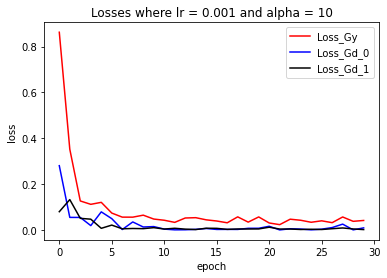

Test Accuracy: 0.484375
Starting epoch 1/30, LR = [0.0001], alpha = 0.1
Gy  Loss 2.0004935264587402
Gd0 Loss 0.6428524851799011
Gd1 Loss 0.32957398891448975
Starting epoch 2/30, LR = [0.0001], alpha = 0.1
Gy  Loss 1.2954462766647339
Gd0 Loss 0.26651352643966675
Gd1 Loss 0.2604466676712036
Starting epoch 3/30, LR = [0.0001], alpha = 0.1
Gy  Loss 1.0060361623764038
Gd0 Loss 0.19535808265209198
Gd1 Loss 0.16562804579734802
Starting epoch 4/30, LR = [0.0001], alpha = 0.1
Gy  Loss 0.7938759326934814
Gd0 Loss 0.21353930234909058
Gd1 Loss 0.12796610593795776
Starting epoch 5/30, LR = [0.0001], alpha = 0.1
Gy  Loss 0.614137589931488
Gd0 Loss 0.15431123971939087
Gd1 Loss 0.11180049180984497
Starting epoch 6/30, LR = [0.0001], alpha = 0.1
Gy  Loss 0.5665042400360107
Gd0 Loss 0.20096343755722046
Gd1 Loss 0.09347014129161835
Starting epoch 7/30, LR = [0.0001], alpha = 0.1
Gy  Loss 0.4275784492492676
Gd0 Loss 0.15313786268234253
Gd1 Loss 0.08143959939479828
Starting epoch 8/30, LR = [0.0001], alpha

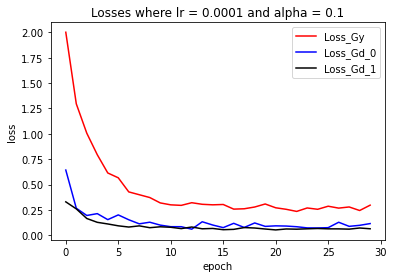

Test Accuracy: 0.45947265625
Starting epoch 1/30, LR = [0.0001], alpha = 0.3
Gy  Loss 2.0575904846191406
Gd0 Loss 0.5862439870834351
Gd1 Loss 0.39617490768432617
Starting epoch 2/30, LR = [0.0001], alpha = 0.3
Gy  Loss 1.4087921380996704
Gd0 Loss 0.39297086000442505
Gd1 Loss 0.14133575558662415
Starting epoch 3/30, LR = [0.0001], alpha = 0.3
Gy  Loss 0.9873428344726562
Gd0 Loss 0.2035091668367386
Gd1 Loss 0.12869340181350708
Starting epoch 4/30, LR = [0.0001], alpha = 0.3
Gy  Loss 0.8181708455085754
Gd0 Loss 0.2034195065498352
Gd1 Loss 0.12539377808570862
Starting epoch 5/30, LR = [0.0001], alpha = 0.3
Gy  Loss 0.6563292145729065
Gd0 Loss 0.11046604812145233
Gd1 Loss 0.13141277432441711
Starting epoch 6/30, LR = [0.0001], alpha = 0.3
Gy  Loss 0.5681746602058411
Gd0 Loss 0.13028529286384583
Gd1 Loss 0.10000255703926086
Starting epoch 7/30, LR = [0.0001], alpha = 0.3
Gy  Loss 0.5063756108283997
Gd0 Loss 0.14090357720851898
Gd1 Loss 0.08097850531339645
Starting epoch 8/30, LR = [0.0001], 

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-v_cjtcal'


Gy  Loss 0.25525572896003723
Gd0 Loss 0.07204495370388031
Gd1 Loss 0.06787265837192535
Starting epoch 29/30, LR = [1.0000000000000002e-06], alpha = 0.3
Gy  Loss 0.24094882607460022
Gd0 Loss 0.057688139379024506
Gd1 Loss 0.06900723278522491
Starting epoch 30/30, LR = [1.0000000000000002e-06], alpha = 0.3
Gy  Loss 0.2833082377910614
Gd0 Loss 0.07638207077980042
Gd1 Loss 0.06010362133383751


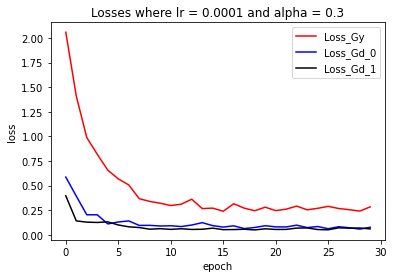

Test Accuracy: 0.42431640625
Starting epoch 1/30, LR = [0.0001], alpha = 1
Gy  Loss 1.7785704135894775
Gd0 Loss 0.5487247109413147
Gd1 Loss 0.411518394947052
Starting epoch 2/30, LR = [0.0001], alpha = 1
Gy  Loss 1.331325650215149
Gd0 Loss 0.373168021440506
Gd1 Loss 0.15468326210975647
Starting epoch 3/30, LR = [0.0001], alpha = 1
Gy  Loss 1.0348517894744873
Gd0 Loss 0.2591427266597748
Gd1 Loss 0.1273694485425949
Starting epoch 4/30, LR = [0.0001], alpha = 1
Gy  Loss 0.762538492679596
Gd0 Loss 0.13578000664710999
Gd1 Loss 0.14611001312732697
Starting epoch 5/30, LR = [0.0001], alpha = 1
Gy  Loss 0.6712028384208679
Gd0 Loss 0.14864712953567505
Gd1 Loss 0.14330559968948364
Starting epoch 6/30, LR = [0.0001], alpha = 1
Gy  Loss 0.5317800641059875
Gd0 Loss 0.12293427437543869
Gd1 Loss 0.11735814809799194
Starting epoch 7/30, LR = [0.0001], alpha = 1
Gy  Loss 0.48769164085388184
Gd0 Loss 0.11963894963264465
Gd1 Loss 0.1117042601108551
Starting epoch 8/30, LR = [0.0001], alpha = 1
Gy  Loss 0

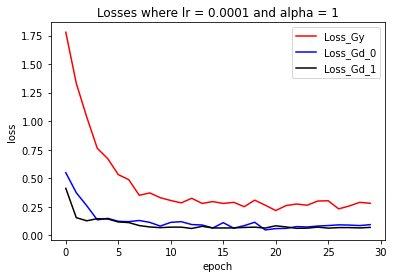

Test Accuracy: 0.43505859375
Starting epoch 1/30, LR = [0.0001], alpha = 3
Gy  Loss 1.8509173393249512
Gd0 Loss 0.6996782422065735
Gd1 Loss 0.4428236782550812
Starting epoch 2/30, LR = [0.0001], alpha = 3
Gy  Loss 1.339332103729248
Gd0 Loss 0.5002317428588867
Gd1 Loss 0.15402424335479736
Starting epoch 3/30, LR = [0.0001], alpha = 3
Gy  Loss 1.004564881324768
Gd0 Loss 0.29214757680892944
Gd1 Loss 0.1326766163110733
Starting epoch 4/30, LR = [0.0001], alpha = 3
Gy  Loss 0.7782393097877502
Gd0 Loss 0.1309327930212021
Gd1 Loss 0.15061116218566895
Starting epoch 5/30, LR = [0.0001], alpha = 3
Gy  Loss 0.6470757722854614
Gd0 Loss 0.194228395819664
Gd1 Loss 0.14580973982810974
Starting epoch 6/30, LR = [0.0001], alpha = 3
Gy  Loss 0.4997119605541229
Gd0 Loss 0.1427105963230133
Gd1 Loss 0.13042743504047394
Starting epoch 7/30, LR = [0.0001], alpha = 3
Gy  Loss 0.43555641174316406
Gd0 Loss 0.1303253471851349
Gd1 Loss 0.10984191298484802
Starting epoch 8/30, LR = [0.0001], alpha = 3
Gy  Loss 0.

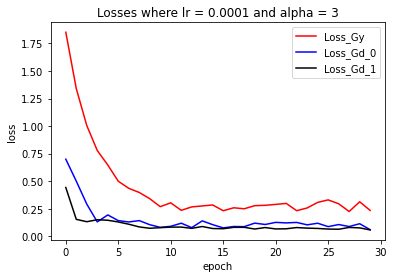

Test Accuracy: 0.3798828125
Starting epoch 1/30, LR = [0.0001], alpha = 10
Gy  Loss 1.898170828819275
Gd0 Loss 0.6568929553031921
Gd1 Loss 0.3473184108734131
Starting epoch 2/30, LR = [0.0001], alpha = 10
Gy  Loss 1.288654088973999
Gd0 Loss 0.29206711053848267
Gd1 Loss 0.21886782348155975
Starting epoch 3/30, LR = [0.0001], alpha = 10
Gy  Loss 0.9849551320075989
Gd0 Loss 0.24973538517951965
Gd1 Loss 0.14218376576900482
Starting epoch 4/30, LR = [0.0001], alpha = 10
Gy  Loss 0.7889034748077393
Gd0 Loss 0.1335916668176651
Gd1 Loss 0.13734659552574158
Starting epoch 5/30, LR = [0.0001], alpha = 10
Gy  Loss 0.5950939655303955
Gd0 Loss 0.1519993543624878
Gd1 Loss 0.12142188102006912
Starting epoch 6/30, LR = [0.0001], alpha = 10
Gy  Loss 0.5042117238044739
Gd0 Loss 0.15182830393314362
Gd1 Loss 0.091783806681633
Starting epoch 7/30, LR = [0.0001], alpha = 10
Gy  Loss 0.375320166349411
Gd0 Loss 0.16295979917049408
Gd1 Loss 0.10256890952587128
Starting epoch 8/30, LR = [0.0001], alpha = 10
Gy 

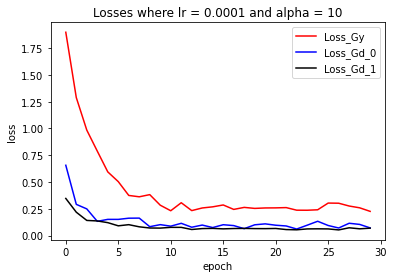

Test Accuracy: 0.43017578125
Starting epoch 1/30, LR = [1e-05], alpha = 0.1
Gy  Loss 2.1235249042510986
Gd0 Loss 0.593708336353302
Gd1 Loss 0.912906289100647
Starting epoch 2/30, LR = [1e-05], alpha = 0.1
Gy  Loss 1.9757046699523926
Gd0 Loss 0.5852664709091187
Gd1 Loss 0.6798526644706726
Starting epoch 3/30, LR = [1e-05], alpha = 0.1
Gy  Loss 1.9491462707519531
Gd0 Loss 0.5762192010879517
Gd1 Loss 0.4728902578353882
Starting epoch 4/30, LR = [1e-05], alpha = 0.1
Gy  Loss 1.855515718460083
Gd0 Loss 0.5291573405265808
Gd1 Loss 0.36108583211898804
Starting epoch 5/30, LR = [1e-05], alpha = 0.1
Gy  Loss 1.771951675415039
Gd0 Loss 0.5038226842880249
Gd1 Loss 0.29725635051727295
Starting epoch 6/30, LR = [1e-05], alpha = 0.1
Gy  Loss 1.7004839181900024
Gd0 Loss 0.5225229263305664
Gd1 Loss 0.2537631392478943
Starting epoch 7/30, LR = [1e-05], alpha = 0.1
Gy  Loss 1.5404648780822754
Gd0 Loss 0.43102332949638367
Gd1 Loss 0.24467118084430695
Starting epoch 8/30, LR = [1e-05], alpha = 0.1
Gy  Los

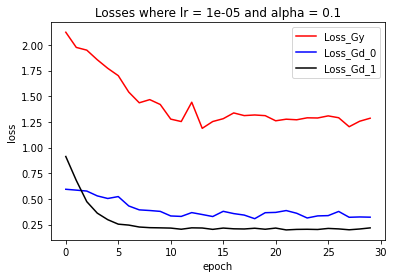

Test Accuracy: 0.25244140625
Starting epoch 1/30, LR = [1e-05], alpha = 0.3
Gy  Loss 2.202651262283325
Gd0 Loss 0.654062032699585
Gd1 Loss 1.0180562734603882
Starting epoch 2/30, LR = [1e-05], alpha = 0.3
Gy  Loss 2.1048941612243652
Gd0 Loss 0.6200724244117737
Gd1 Loss 0.7737666964530945
Starting epoch 3/30, LR = [1e-05], alpha = 0.3
Gy  Loss 1.9466750621795654
Gd0 Loss 0.6646334528923035
Gd1 Loss 0.5162720084190369
Starting epoch 4/30, LR = [1e-05], alpha = 0.3
Gy  Loss 1.8656284809112549
Gd0 Loss 0.6374940872192383
Gd1 Loss 0.4084165096282959
Starting epoch 5/30, LR = [1e-05], alpha = 0.3
Gy  Loss 1.7443207502365112
Gd0 Loss 0.5603607296943665
Gd1 Loss 0.313414067029953
Starting epoch 6/30, LR = [1e-05], alpha = 0.3
Gy  Loss 1.6847336292266846
Gd0 Loss 0.5191735029220581
Gd1 Loss 0.280305415391922
Starting epoch 7/30, LR = [1e-05], alpha = 0.3
Gy  Loss 1.5363667011260986
Gd0 Loss 0.5297292470932007
Gd1 Loss 0.2604024112224579
Starting epoch 8/30, LR = [1e-05], alpha = 0.3
Gy  Loss 1.

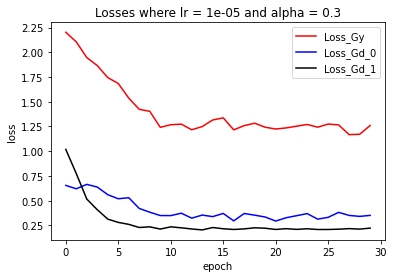

Test Accuracy: 0.228515625
Starting epoch 1/30, LR = [1e-05], alpha = 1
Gy  Loss 1.9467239379882812
Gd0 Loss 0.8394153714179993
Gd1 Loss 0.8360211253166199
Starting epoch 2/30, LR = [1e-05], alpha = 1
Gy  Loss 1.8618675470352173
Gd0 Loss 0.7942619323730469
Gd1 Loss 0.6282953023910522
Starting epoch 3/30, LR = [1e-05], alpha = 1
Gy  Loss 1.7771567106246948
Gd0 Loss 0.7046837210655212
Gd1 Loss 0.48418179154396057
Starting epoch 4/30, LR = [1e-05], alpha = 1
Gy  Loss 1.6997309923171997
Gd0 Loss 0.6841648817062378
Gd1 Loss 0.3895625174045563
Starting epoch 5/30, LR = [1e-05], alpha = 1
Gy  Loss 1.5805227756500244
Gd0 Loss 0.6364423632621765
Gd1 Loss 0.3348456621170044
Starting epoch 6/30, LR = [1e-05], alpha = 1
Gy  Loss 1.4784682989120483
Gd0 Loss 0.5372046828269958
Gd1 Loss 0.293618768453598
Starting epoch 7/30, LR = [1e-05], alpha = 1
Gy  Loss 1.3468958139419556
Gd0 Loss 0.44946569204330444
Gd1 Loss 0.2596300542354584
Starting epoch 8/30, LR = [1e-05], alpha = 1
Gy  Loss 1.3452476263046

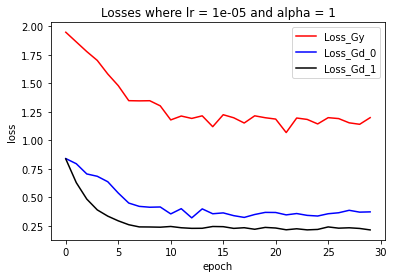

Test Accuracy: 0.25537109375
Starting epoch 1/30, LR = [1e-05], alpha = 3
Gy  Loss 2.2750988006591797
Gd0 Loss 0.6863750219345093
Gd1 Loss 0.7431091070175171
Starting epoch 2/30, LR = [1e-05], alpha = 3
Gy  Loss 2.186986207962036
Gd0 Loss 0.690966784954071
Gd1 Loss 0.6132791638374329
Starting epoch 3/30, LR = [1e-05], alpha = 3
Gy  Loss 2.110142469406128
Gd0 Loss 0.6679664850234985
Gd1 Loss 0.4465257525444031
Starting epoch 4/30, LR = [1e-05], alpha = 3
Gy  Loss 2.003669500350952
Gd0 Loss 0.6514884233474731
Gd1 Loss 0.3765256702899933
Starting epoch 5/30, LR = [1e-05], alpha = 3
Gy  Loss 1.8511788845062256
Gd0 Loss 0.5720048546791077
Gd1 Loss 0.3078451156616211
Starting epoch 6/30, LR = [1e-05], alpha = 3
Gy  Loss 1.7128618955612183
Gd0 Loss 0.4916686713695526
Gd1 Loss 0.2747103273868561
Starting epoch 7/30, LR = [1e-05], alpha = 3
Gy  Loss 1.6690763235092163
Gd0 Loss 0.46403124928474426
Gd1 Loss 0.2575744390487671
Starting epoch 8/30, LR = [1e-05], alpha = 3
Gy  Loss 1.641761064529419

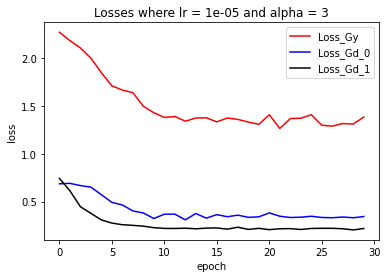

Test Accuracy: 0.265625
Starting epoch 1/30, LR = [1e-05], alpha = 10
Gy  Loss 2.118208646774292
Gd0 Loss 1.1540330648422241
Gd1 Loss 0.5397961139678955
Starting epoch 2/30, LR = [1e-05], alpha = 10
Gy  Loss 2.07230281829834
Gd0 Loss 1.042541742324829
Gd1 Loss 0.4545413553714752
Starting epoch 3/30, LR = [1e-05], alpha = 10
Gy  Loss 1.968921184539795
Gd0 Loss 0.8783749341964722
Gd1 Loss 0.42051178216934204
Starting epoch 4/30, LR = [1e-05], alpha = 10
Gy  Loss 1.8802380561828613
Gd0 Loss 0.804235577583313
Gd1 Loss 0.3565692603588104
Starting epoch 5/30, LR = [1e-05], alpha = 10
Gy  Loss 1.6923953294754028
Gd0 Loss 0.6827687621116638
Gd1 Loss 0.3455408215522766
Starting epoch 6/30, LR = [1e-05], alpha = 10
Gy  Loss 1.6877541542053223
Gd0 Loss 0.5884066820144653
Gd1 Loss 0.3166241943836212
Starting epoch 7/30, LR = [1e-05], alpha = 10
Gy  Loss 1.5176441669464111
Gd0 Loss 0.5073685050010681
Gd1 Loss 0.2969031035900116
Starting epoch 8/30, LR = [1e-05], alpha = 10
Gy  Loss 1.45363283157348

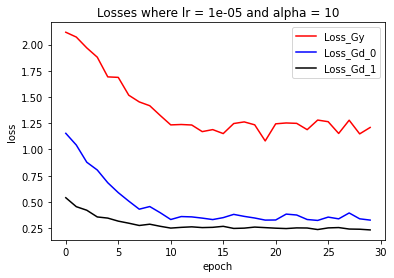

Test Accuracy: 0.22802734375


In [42]:
for lr in lr_choices:
    for alpha in alpha_choices:
        # prepare network
        net = dann(pretrained=True) 
        net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
        net.domain_clf[1].weight.data = net.classifier[1].weight.data
        net.domain_clf[1].bias.data = net.classifier[1].bias.data
        net.domain_clf[4].weight.data = net.classifier[4].weight.data
        net.domain_clf[4].bias.data = net.classifier[4].bias.data

        # prepare optimizer
        criterion = nn.CrossEntropyLoss()
        parameters_to_optimize = net.parameters()
        optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

        net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
        cudnn.benchmark # Calling this optimizes runtime

        loss_Gy_hist = []
        loss_Gd_0_hist = []
        loss_Gd_1_hist = []

        # training phase
        for epoch in range(NUM_EPOCHS):
            print('Starting epoch {}/{}, LR = {}, alpha = {}'.format(
                epoch+1, NUM_EPOCHS, scheduler.get_last_lr(), alpha
                ))
            logger.info('Starting epoch {}/{}, LR = {}, alpha = {}'.format(
                epoch+1, NUM_EPOCHS, scheduler.get_last_lr(), alpha
                ))

            # Iterate over the dataset
            for images, labels in train_dataloader:
                # Bring data over the device of choice
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                net.train() # Sets module in training mode

                # PyTorch, by default, accumulates gradients after each backward pass
                # We need to manually set the gradients to zero before starting a new iteration
                optimizer.zero_grad() # Zero-ing the gradients

                # 3B.1 Train Gy
                # Forward pass to the network
                outputs = net(images)

                # Compute loss based on output and ground truth
                loss = criterion(outputs, labels)

                loss.backward()  # backward pass: computes gradients

                # 3B.2 Train Gd by forwarding source data
                label_outputs = net.forward(images, alpha)
                targets = torch.zeros(labels.shape, dtype=int).to(DEVICE)

                loss_Gd_0 = criterion(label_outputs, targets)
                loss_Gd_0.backward()

                # 3B.3 Train Gd by forwarding target data
                test_images, test_labels = next(iter(test_dataloader))
                test_images = test_images.to(DEVICE)
                test_labels = test_labels.to(DEVICE)

                test_label_outputs = net.forward(test_images, alpha)
                targets = torch.ones(test_labels.shape, dtype=int).to(DEVICE)

                loss_Gd_1 = criterion(test_label_outputs, targets)
                loss_Gd_1.backward()

                # update weights based on accumulated gradients
                optimizer.step() 

            # Step the scheduler
            scheduler.step()

            # Log loss
            print('Gy  Loss {}'.format(loss.item()))
            print('Gd0 Loss {}'.format(loss_Gd_0.item()))
            print('Gd1 Loss {}'.format(loss_Gd_1.item()))
            logger.info('Gy  Loss {}'.format(loss.item()))
            logger.info('Gd0 Loss {}'.format(loss_Gd_0.item()))
            logger.info('Gd1 Loss {}'.format(loss_Gd_1.item()))

            # Record loss and accuracy after each epoch
            loss_Gy_hist.append(loss.item())
            loss_Gd_0_hist.append(loss_Gd_0)
            loss_Gd_1_hist.append(loss_Gd_1)

        plot_loss(lr, alpha, loss_Gy_hist, loss_Gd_0_hist, loss_Gd_1_hist)
        
        # testing phase
        net.train(False) # Set Network to evaluation mode

        running_corrects = 0
        for images, labels in test_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward Pass
            outputs = net(images)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)

            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

        # Calculate Accuracy
        accuracy = running_corrects / float(len(test_dataset))
        print('Test Accuracy: {}'.format(accuracy))

        if accuracy > best_accuracy:
            best_net = deepcopy(net)
            best_lr = lr
            best_alpha = alpha
            best_accuracy = accuracy

In [43]:
best_lr, best_alpha, best_accuracy

(0.001, 10, 0.484375)

In [44]:
torch.save(best_net.state_dict, 'DANN.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type DANN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
!cp 'DANN.pkl' '/gdrive/My Drive/DANN.pkl'
!cp 'DANN.log' '/gdrive/My Drive/DANN.log'